In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

/data/yanghq/utils/anaconda3/envs/glm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data/yanghq/utils/anaconda3/envs/glm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /data/yanghq/models/google-bert/bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


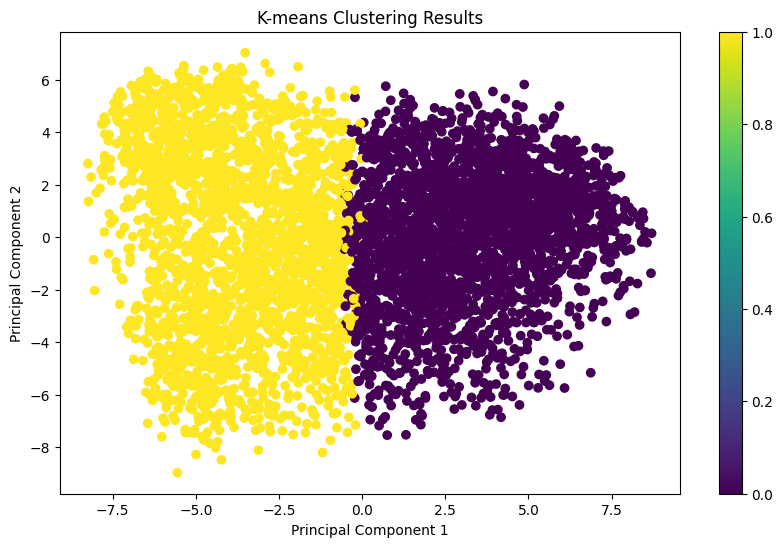

In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

file_path = "/data/yanghq/datasets/nlp/ori.xlsx"
df = pd.read_excel(file_path)

def preprocess_text(text):
    text = str(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['投诉内容'] = df['投诉内容'].apply(preprocess_text)
texts = df['投诉内容'].tolist()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("/data/yanghq/models/google-bert/bert-base-chinese")
model = AutoModel.from_pretrained("/data/yanghq/models/google-bert/bert-base-chinese")
model.to(device)
model.eval()

def extract_features(texts, tokenizer, model, device, batch_size=8):
    features = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        features.extend(cls_embeddings)
    return features

features = extract_features(texts, tokenizer, model, device, 64)

def find_optimal_k(features, k_range):
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(features)
        score = silhouette_score(features, kmeans.labels_)
        silhouette_scores.append(score)
    return silhouette_scores

k_range = range(2, 52, 10)
#silhouette_scores = find_optimal_k(features, k_range)

# plt.figure(figsize=(10, 6))
# plt.plot(k_range, silhouette_scores, marker='o')
# plt.title('Silhouette Score for different k')
# plt.xlabel('Number of clusters, k')
# plt.ylabel('Silhouette Score')
# plt.show()

# optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
# print('optimal_k = ',optimal_k)
optimal_k=2
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(features)
labels = kmeans.labels_

def plot_clusters(features, labels):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
    plt.title('K-means Clustering Results')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter)
    plt.show()

plot_clusters(features, labels)

df['Cluster'] = labels
output_path = "/data/yanghq/datasets/nlp/clustered_complaints.xlsx"
df.to_excel(output_path, index=False)
